In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

The Metropolis algorithm performs a random walk that uses an acceptance/rejection rule to sample from a target distribution.

Consider sampling from a posterior distribution $p\left(\theta\,\middle|\,y\right)$. The samples are a sequence $\theta_1, \theta_2, \theta_3, \ldots,$ where the transitions are dictated by a jumping/proposal distribution 

$$ \theta^* \sim J_t\left(\theta^*\,\middle|\,\theta^{t-1}\right) $$

where $\theta^*$ is a proposed step.

We decide whether to accept the step based on the posterior probabilities: let

$$ r = \frac{p\left(\theta^*\, \middle|\, y\right)}{p\left(\theta^{t-1}\,\middle|\,y\right)} $$

and set $\theta^t = \theta^*$ with probability $\min \left(1,r\right)$; otherwise let $\theta^t = \theta^{t-1}$.

### Example: bivariate unit normal

Target distribution:

$$ p\left(\theta\,\middle|\,y\right) = \mathcal{N}\left(\theta; 0, I\right) $$

Jumping distribution:

$$ J_t\left(\theta^*\,\middle|\,\theta^{t-1}\right) = \mathcal{N}\left(\theta^*\,\middle|\,\theta^{t-1}, 0.2^2 I \right) $$

The ratio is

\begin{align*}
    r & = \frac{p\left(\theta^* \,\middle|\,y\right)}{J_t\left(\theta^*\, \middle|\, \theta^{t-1}\right)} \\
    & = \frac{\mathcal{N}\left(\theta^*\,\middle|\, 0, I\right)}{\mathcal{N}\left(\theta^* \, \middle|\, \theta^{t-1}, 0.2^2 I\right)} \\
\end{align*}

\begin{align*}
    \log r & = \log \mathcal{N}\left(\theta^*\,\middle|\, 0, I\right) - \log \mathcal{N}\left(\theta^* \, \middle|\, \theta^{t-1}, 0.2^2 I\right) \\
    & = -\log 2\pi + \frac{1}{2} \log \left(2\pi\right)^2 0.2^4 - \frac{1}{2}\left(\theta^*\right)^T \theta^* + \frac{1}{2}\left(\theta^* - \theta^{t-1}\right)^T \left(\theta^* - \theta^{t-1}\right) / 0.2^4  \\
\end{align*}

In [52]:
theta = np.array([0.5, 0.5])

def draw_proposal(theta):
    """ theta: current value """
    n_dims = len(theta)
    scale = 0.2 ** n_dims

    return ss.multivariate_normal(mean=theta, cov=scale*np.eye(n_dims)).rvs()

$$ p\left(\theta\,\middle|\,y\right) = \mathcal{N}\left(\theta\,\middle|\, 0, I\right)$$

In [89]:

def metropolis_step(theta):
    n_dims = len(theta)
    scale = 0.2**n_dims
    
    # draw a proposal
    theta_prop = draw_proposal(theta)
    dist = ss.multivariate_normal(mean=np.zeros(n_dims), cov=np.eye(n_dims))
    log_r = np.log(dist.pdf(theta_prop)) - np.log(dist.pdf(theta))
    r = np.exp(log_r)
    p = np.min([1, r])

    z = ss.uniform(0,1).rvs()
    return theta_prop if z <= p else theta

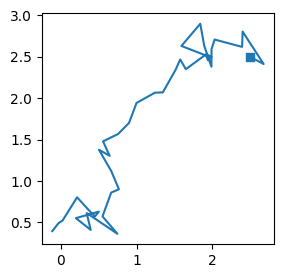

In [91]:
theta = np.array([2.5, 2.5])

history = []

for n in range(50):
    theta = metropolis_step(theta)
    history.append(theta)

h = np.stack(history)

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(h[:,0], h[:,1])
ax.scatter(h[0,0], h[0,1], marker='s')
plt.show()

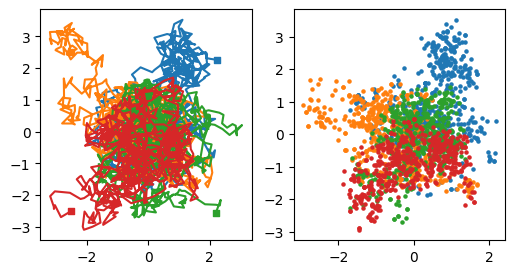

In [96]:
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
theta = np.array([2.5, 2.5])
for theta in [
    [2.5, 2.5],
    [-2.5, 2.5],
    [2.5, -2.5],
    [-2.5, -2.5],
]:
    theta = np.array(theta)
    history = []
    n_iters = 1_000
    for n in range(n_iters):
        theta = metropolis_step(theta)
        history.append(theta)

    h = np.stack(history)

    n_plot = n_iters // 2
    ax[0].plot(h[:,0], h[:,1])
    ax[0].scatter(h[0,0], h[0,1], marker='s', s=20)
    ax[1].scatter(h[n_plot:,0], h[n_plot:,1], marker='.', s=20)
plt.show()

The Metropolis algorithm requires that the jumping distribution is symmetric.

# Metropolis-Hastings

The Metropolis-Hastings algorithm is a generalization of the Metropolis algorithm which permits asymmetry in the jumping distribution. This is accounted for by including the jumping distribution in the posterior probablity ratio.

The ratio is

\begin{align*}
    r & = \left[\frac{p\left(\theta^* \,\middle|\,y\right)}{J_t\left(\theta^*\, \middle|\, \theta^{t-1}\right)} \right] / \left[ \frac{p\left(\theta^{t-1}\,\middle|\, y\right)}{J_t\left(\theta^{t-1}\,\middle|\, \theta^*\right)}\right] \\
\end{align*}

In [109]:

def metropolis_hastings_step(theta):
    n_dims = len(theta)
    scale = 0.2**n_dims
    I = np.eye(n_dims)

    # draw a proposal
    theta_prop = draw_proposal(theta)
    
    # Create distributions
    post_pdf = ss.multivariate_normal(mean=np.zeros(n_dims), cov=np.eye(n_dims)).pdf
    j_dist_pdf = lambda mu: ss.multivariate_normal(mean=mu, cov=scale*I).pdf

    log_r = np.log(post_pdf(theta_prop)) - np.log(j_dist_pdf(theta)(theta_prop)) \
        - np.log(post_pdf(theta)) + np.log(j_dist_pdf(theta_prop)(theta))
    r = np.exp(log_r)
    p = np.min([1, r])

    z = ss.uniform(0,1).rvs()
    if z <= p:
        # accept step
        return theta_prop, 1
    else:
        return theta, 0

In [136]:
history = dict()
thetas =[[2.5, 2.5],[-2.5, 2.5], [2.5,-2.5], [-2.5,-2.5]]
n_chains = len(thetas)
n_iters_per_chain = 1_000
n_dims = len(thetas[0])

def init_hist_chain(nipc, nd):
    return {
    "theta": np.zeros((nipc, nd)),
    "accept": np.zeros((nipc), dtype=int),
}
history = {c_idx: init_hist_chain(n_iters_per_chain, n_dims) for c_idx in range(n_chains)}

for chain_idx, theta in enumerate(thetas):
    theta = np.array(theta)
    for n in range(n_iters_per_chain):
        theta, accept = metropolis_hastings_step(theta)
        
        # record step
        history[chain_idx]["theta"][n] = theta
        history[chain_idx]["accept"][n] = accept

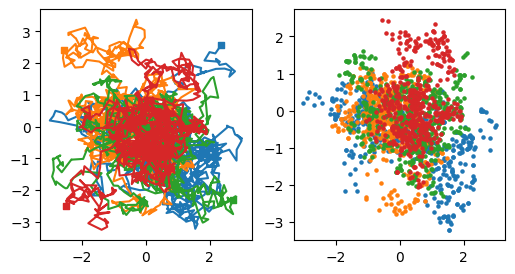

In [142]:

fig, ax = plt.subplots(figsize=(6, 3), ncols=2)

n_plot = n_iters // 2

for c_idx in range(n_chains):
    theta_c = history[c_idx]['theta']
    ax[0].plot(theta_c[:,0], theta_c[:,1])
    ax[0].scatter(theta_c[0,0], theta_c[0,1], marker='s', s=20)
    ax[1].scatter(theta_c[n_plot:, 0], theta_c[n_plot:, 1], marker='.', s=20)
plt.show()

# What next?

We have a collection of draws which are (purportedly) from our posterior distribution of interest. We can use these draws to perform inference: summarize the posterior density, compute quantiles, moments, etc.

We can do posterior predictive simulations by simulating conditional on the drawn values of the parameters.

In [154]:
# posterior predictive simulation
n_post_samples = 200
rand_idx = np.random.choice(range(500), size=n_post_samples, replace=False)
theta_draws = history[0]['theta'][rand_idx, :]

y_hat = np.zeros((n_post_samples, 2))
for i in range(n_post_samples):
    y_hat[i] = ss.multivariate_normal(mean=theta_draws[i], cov=np.eye(2)).rvs()

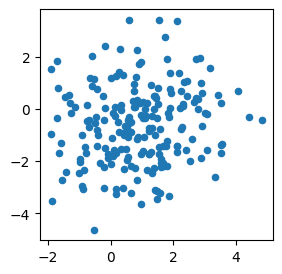

In [158]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y_hat[:,0], y_hat[:,1], s=20)
plt.show()

Is it safe to do this? Two issues:

* If chains are not long enough, samples will not represent the target distribution. This can be solved by discarding a **warm-up** or **burn-in** period, i.e., the early samples in the chain.
* A particular chain may present high within-chain correlation, though we want to treat the samples in the chain as independent from one another. (It seems obvious that they'd be correlated, since this is a random walk?) We can compare multiple chains to assess this.

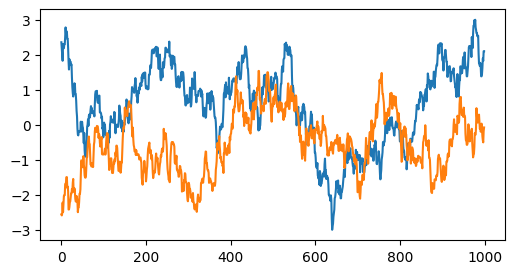

In [163]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(history[0]['theta'][:,0])
ax.plot(history[1]['theta'][:,0])
plt.show()

These chains clearly have not converged, though they may be sampling a common distribution!

#### Checking mixing

The first step is to split the chains (minus burn-in period) in half and check that all half-chains (across chains) are "mixed."

In [175]:
burn_in = 500
c_idx = 0

half_chains = []
for chain in history:
    chain_bi = history[chain]['theta'][burn_in:, :]
    half_chains.append(chain_bi[:250,:])
    half_chains.append(chain_bi[250:,:])

m = len(half_chains)
n = 250

In [196]:
# compute between-sequence variance of theta_1 or theta_2
# param_idx = 0 # theta_1
param_idx = 1 # theta_2

psi_bar_dot = []
sj2 = []
for j in range(m):
    chain = half_chains[j]
    psi = chain[:,param_idx]
    psi_bar_dot.append(psi.sum() / n)

    sj2.append(np.sum((psi - psi_bar_dot[-1])**2) / (n-1))
    
psi_bar_dotdot = sum(psi_bar_dot) / m

B = n * np.sum((psi_bar_dot - psi_bar_dotdot)**2) / (m-1)
W = np.sum(sj2) / m

var_theta_1 = (n-1) * W / n + B / n
print(var_theta_1)

# estimate potential scale reduction by taking n-> infty
print(np.sqrt(var_theta_1 / W))


0.8993215331975906
1.1642950341316136


### Checking effective number of draws

In [202]:
param_idx = 0
chain = half_chains[0][:,param_idx]

t = np.arange(1, len(chain)+1)

In [233]:
param_idx = 1
V_t = np.zeros(250)

for t in range(1,250):
    v_t = 0.0
    for c_idx in range(m):
        chain = half_chains[c_idx][:,param_idx]
        v_t += np.sum((chain[t+1:n] - chain[1:n-t])**2)

    V_t[t] = v_t / (m * (n-t))


In [234]:
rho_t = 1 - V_t / (2 * var_theta_1)

In [244]:
T = np.where((rho_t[:-1] + rho_t[1:]) < 0)[0][0]

In [246]:
m*n / (1 + 2 * rho_t[:T].sum())

26.981921284741112